# MoodWave: Voice-Driven Emotion Detection

## Data Guidelines

Your dataset must be:

- Appropriate for classification. It should have a categorical outcome or the data needed to engineer one.

- Usable to solve a specific business problem. This solution must rely on your classification model.

- Somewhat complex. It should contain a minimum of 1000 rows and 10 features.

- Unfamiliar. It can't be one we've already worked with during the course or that is commonly used for demonstration purposes (e.g. Titanic).

- Manageable. Stick to datasets that you can model using the techniques introduced in Phase 3.


### Phase 3 Concepts used in this project:

- Logistic Regression:

> Logistic regression is a fundamental classification algorithm that's well-suited for binary and multiclass classification tasks. It's a good choice if your dataset has clear decision boundaries.

- Decision Trees:

> Decision trees are versatile and interpretable models that can handle both categorical and continuous data. They are particularly useful when you want to understand the decision-making process of your model.

- Evaluation Metrics (Confusion Matrices, ROC Curves, AUC):

> These metrics are essential for assessing the performance of your classification model. They will help you understand how well your model distinguishes between different emotional states.

- Hyperparameter Tuning and Pruning:

> When using decision trees, tuning hyperparameters and pruning are important to avoid overfitting and to ensure your model generalizes well to new data.

- Binary Classification

> When audio augmentation did not prove (too) effective, ... [TODO]

## Data Understanding

In this project, we are dealing with four datasets containing audio recordings in the .wav format. Each audio recording is labeled with an emotion that the speaker is evoking in their statement. Our goal is to build a model that can successfully map an emotion to a given voice clip of someone speaking.

To achieve this, we will extract various features from the audio recordings that are relevant for analyzing speech and emotion. Here are the features we will be working with and their significance:

1. **Mel-frequency Cepstral Coefficients (MFCCs):** MFCCs are a compact representation of the short-term power spectrum of a sound. They are widely used in speech recognition and audio analysis tasks because they capture the essential characteristics of the audio signal while being robust to noise and other variabilities. MFCCs are particularly useful for identifying the phonetic content of speech, which can be helpful in determining the emotional state of the speaker.

2. **Spectral Centroid:** The spectral centroid is a measure of the brightness or sharpness of a sound. It represents the weighted mean frequency of the spectrum and can be used to distinguish between different types of sounds or emotions. For example, a bright, harsh sound might have a higher spectral centroid than a mellow, soft sound.

3. **Chroma Features:** Chroma features describe the distribution of energy across different pitch classes (notes) in the audio signal. They are useful for capturing tonal information, which can be relevant for identifying emotions in speech, particularly those related to intonation patterns and stress.

4. **Zero-Crossing Rate:** The zero-crossing rate is a measure of the number of times the audio signal crosses the zero amplitude axis within a given time frame. It can be used to distinguish between different types of sounds, such as voiced and unvoiced speech, and can provide insights into the energy distribution of the audio signal.
RMS Energy: The Root Mean Square (RMS) energy is a measure of the overall energy or loudness of an audio signal. It can be useful for detecting variations in volume or intensity, which can be indicative of certain emotions, such as anger or excitement.

5. **Pitch:** The pitch feature represents the fundamental frequency of the audio signal. It is closely related to the perception of tone and can be useful for analyzing the intonation patterns and stress levels in speech, which can be indicators of different emotional states.

---

By extracting and analyzing these features, we can capture various acoustic characteristics of the speech signal that may be relevant for distinguishing between different emotions. This multi-faceted approach can provide a more comprehensive representation of the audio data, potentially leading to better performance in the emotion classification task.

## Data Preperation

Here 4 most popular datasets in English: Crema, Ravdess, Savee and Tess. Each of them contains audio in .wav format with some main labels.

Because our data isn't inherinantly in a csv / dataframe format, we will have to create it from scratch!

First, we will pull all data into their own dataframe, making note of *where* the file is, so we can later pull our features from each audio file. 

After each dataset has been imported into its own dataframe, we will merge them all into one dataframe. Then, we can extract our desired audio features:

- Mel-frequency cepstral coefficients (MFCCs)
- Spectral centroid
- Chroma features
- Zero-crossing rate
- RMS energy
- Pitch



In [65]:
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import zipfile
import librosa
import random
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.utils import class_weight


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scipy.stats import skew, kurtosis
from collections import Counter


In [66]:
# data is zipped, and stored in folders for which dataset they came from:

# Define the path to the zipped dataset
zip_file_path = 'dataset.zip'
extracted_folder_path = 'dataset'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Crema
# Ravdess
# Savee
# Tess

In [67]:
# Define the path to the Crema folder
crema_folder_path = os.path.join(extracted_folder_path, 'Crema')

# Verify that we can access the files and extract emotion labels
data = []

# Loop through each file in the Crema folder
for file_name in os.listdir(crema_folder_path):
    if file_name.endswith('.wav'):
        # Extract the emotion label from the filename
        parts = file_name.split('_')
        emotion_code = parts[2]
        
        # Map the emotion code to the actual emotion label
        emotion_map = {
            'SAD': 'sadness',
            'ANG': 'angry',
            'DIS': 'disgust',
            'FEA': 'fear',
            'HAP': 'happy',
            'NEU': 'neutral'
        }
        emotion_label = emotion_map.get(emotion_code, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({'filename': file_name, 'emotion': emotion_label, 'path': crema_folder_path})

# Convert the data into a DataFrame for easy access
df_crema = pd.DataFrame(data)

# Display the first few rows to verify
print(df_crema.head())

              filename  emotion           path
0  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [68]:
# Define the path to the Tess folder
tess_folder_path = os.path.join(extracted_folder_path, 'Tess')

# Prepare to store the data
data = []

# Loop through each emotion folder in the Tess directory
for emotion_folder in os.listdir(tess_folder_path):
    # Get the full path to the emotion folder
    emotion_folder_path = os.path.join(tess_folder_path, emotion_folder)
    
    # Extract the emotion from the folder name (e.g., "OAF_angry" -> "angry")
    emotion_label = emotion_folder.split('_')[1]
    
    # Loop through each file in the emotion folder
    for file_name in os.listdir(emotion_folder_path):
        if file_name.endswith('.wav'):
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': emotion_folder_path
            })

# Convert the data into a DataFrame for easy access
df_tess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_tess.head())

             filename emotion                    path
0  OAF_back_angry.wav   angry  dataset\Tess\OAF_angry
1   OAF_bar_angry.wav   angry  dataset\Tess\OAF_angry
2  OAF_base_angry.wav   angry  dataset\Tess\OAF_angry
3  OAF_bath_angry.wav   angry  dataset\Tess\OAF_angry
4  OAF_bean_angry.wav   angry  dataset\Tess\OAF_angry


In [69]:
# Define the path to the Savee folder
savee_folder_path = os.path.join(extracted_folder_path, 'Savee')

# Prepare to store the data
data = []

# Define the emotion mapping based on the prefixes
emotion_map = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

# Loop through each file in the Savee folder
for file_name in os.listdir(savee_folder_path):
    if file_name.endswith('.wav'):
        # Extract the prefix from the filename to determine the emotion
        prefix = file_name.split('_')[1][:2]
        
        # Map the prefix to the corresponding emotion
        emotion_label = emotion_map.get(prefix, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({
            'filename': file_name, 
            'emotion': emotion_label, 
            'path': savee_folder_path
        })

# Convert the data into a DataFrame for easy access
df_savee = pd.DataFrame(data)

# Display the first few rows to verify
print(df_savee.head())

     filename  emotion           path
0  DC_a01.wav  unknown  dataset\Savee
1  DC_a02.wav  unknown  dataset\Savee
2  DC_a03.wav  unknown  dataset\Savee
3  DC_a04.wav  unknown  dataset\Savee
4  DC_a05.wav  unknown  dataset\Savee


In [70]:
# Define the path to the Ravdess folder
ravdess_folder_path = os.path.join(extracted_folder_path, 'Ravdess', 'audio_speech_actors_01-24')

# Prepare to store the data
data = []

# Define the emotion mapping based on the third component in the filename
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Loop through each actor's folder in the Ravdess directory
for actor_folder in os.listdir(ravdess_folder_path):
    actor_folder_path = os.path.join(ravdess_folder_path, actor_folder)
    
    # Loop through each file in the actor's folder
    for file_name in os.listdir(actor_folder_path):
        if file_name.endswith('.wav'):
            # Extract the third component from the filename to determine the emotion
            emotion_code = file_name.split('-')[2]
            
            # Map the emotion code to the corresponding emotion label
            emotion_label = emotion_map.get(emotion_code, 'unknown')
            
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': actor_folder_path
            })

# Convert the data into a DataFrame for easy access
df_ravdess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_ravdess.head())

                   filename  emotion  \
0  03-01-01-01-01-01-01.wav  neutral   
1  03-01-01-01-01-02-01.wav  neutral   
2  03-01-01-01-02-01-01.wav  neutral   
3  03-01-01-01-02-02-01.wav  neutral   
4  03-01-02-01-01-01-01.wav     calm   

                                                path  
0  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
1  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
2  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
3  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
4  dataset\Ravdess\audio_speech_actors_01-24\Acto...  


### Combining datasets 

We will merge the datsets into one dataframe, and assign unique identifiers
- Concatenate the DataFrames for each dataset.
- Assign a unique ID to each entry based on the dataset.

In [71]:
# Add a unique ID column to each dataset
df_crema['id'] = ['c_{:04d}'.format(i + 1) for i in range(len(df_crema))]
df_tess['id'] = ['t_{:04d}'.format(i + 1) for i in range(len(df_tess))]
df_savee['id'] = ['s_{:04d}'.format(i + 1) for i in range(len(df_savee))]
df_ravdess['id'] = ['r_{:04d}'.format(i + 1) for i in range(len(df_ravdess))]

# Merge the datasets into a single DataFrame
merged_data = pd.concat([df_crema, df_tess, df_savee, df_ravdess], ignore_index=True)

# Reorder columns to have 'id' as the first column
merged_data = merged_data[['id', 'filename', 'emotion', 'path']]

# Display the first few rows of the combined DataFrame
print(merged_data.head())

       id             filename  emotion           path
0  c_0001  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  c_0002  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  c_0003  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  c_0004  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  c_0005  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [72]:
# remember, we need at least 1000 rows to meet our requirements. 
print(f"Total rows in dataset: {merged_data.shape[0]}")

Total rows in dataset: 12162


### Extracting Features

Again, these are the features we will extract:

- **Mel-frequency cepstral coefficients (MFCCs):** Represents the short-term power spectrum of sound, commonly used in speech and audio processing to capture the timbral texture of audio. We extract the **mean**, **standard deviation**, **skewness**, and **kurtosis** of the MFCCs.

- **Spectral centroid:** Indicates the "center of mass" of the spectrum and is often associated with the perceived brightness of a sound. We extract the **mean**, **standard deviation**, **skewness**, and **kurtosis** of the spectral centroid.

- **Chroma features:** Represents the 12 different pitch classes and captures harmonic and melodic characteristics of music or voice. We extract the **mean** and **standard deviation** of the chroma features.

- **Zero-crossing rate (ZCR):** Measures the rate at which the signal changes sign, giving insight into the noisiness or percussiveness of the sound. We extract the **mean** and **standard deviation** of the zero-crossing rate.

- **RMS energy:** Reflects the root mean square of the audio signal and indicates the energy or loudness of the sound. We extract the **mean** and **standard deviation** of the RMS energy.

- **Spectral bandwidth:** Measures the width of the frequency band, providing information about the range of frequencies present in the sound. We extract the **mean** and **standard deviation** of the spectral bandwidth.

- **Spectral rolloff:** Represents the frequency below which a certain percentage (typically 85%) of the total spectral energy is contained. We extract the **mean** and **standard deviation** of the spectral rolloff.

- **Tonnetz:** Represents the tonal centroids, which capture harmonic relationships in audio. We extract the **mean** and **standard deviation** of the tonal centroids.

- **Pitch:** Refers to the perceived frequency of a sound, determining how high or low a sound is. We extract the **mean** and **standard deviation** of the pitch.

We will be using the `librosa` package to process these audio features. [Here](https://librosa.org/doc/latest/index.html) is a link to the librosa documentation.

**Note**: adding suppression for *UserWarning: Trying to estimate tuning from empty frequency set*. This is likely do to either:* **silence / low energy** (too quiet to perform reliable pitch estimation), or the file had **too short of a duration**. This warning shows up even when setting the pitch to 0 in this case.


In [79]:
def extract_features(data, sr=None, from_file=True):
    if from_file:
        y, sr = librosa.load(data, sr=sr)
    else:
        y = data

    if len(y) == 0:
        print(f"Warning: The file {data} is empty.")
        return (np.zeros(13), np.zeros(4), np.zeros(12), 0, 0, 0, 0)

    # Extract MFCCs and compute statistics
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = mfccs.mean(axis=1)
    mfccs_std = mfccs.std(axis=1)
    mfccs_skewness = np.apply_along_axis(lambda x: np.mean((x - np.mean(x))**3) / (np.std(x)**3 + 1e-6), axis=1, arr=mfccs)
    mfccs_kurtosis = np.apply_along_axis(lambda x: np.mean((x - np.mean(x))**4) / (np.std(x)**4 + 1e-6), axis=1, arr=mfccs)

    # Extract spectral centroid and compute statistics
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_std = np.std(spectral_centroid)
    spectral_centroid_skewness = np.mean((spectral_centroid - spectral_centroid_mean)**3) / (spectral_centroid_std**3 + 1e-6)
    spectral_centroid_kurtosis = np.mean((spectral_centroid - spectral_centroid_mean)**4) / (spectral_centroid_std**4 + 1e-6)

    # Extract other features
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)

    # Extract pitch using the piptrack function
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0

    # Return all the features in a tuple
    return (
        mfccs_mean,
        mfccs_std,   
        mfccs_skewness,  
        mfccs_kurtosis,  
        [spectral_centroid_mean, spectral_centroid_std, spectral_centroid_skewness, spectral_centroid_kurtosis],  
        chroma,  
        zero_crossing_rate,  
        rms,  
        pitch
    )

In [80]:
# testing our extract_features function:
first_row = merged_data.iloc[0]
file_path = os.path.join(first_row['path'], first_row['filename'])

# Extract features directly from the file path
features = extract_features(file_path)

# Print out each feature with its corresponding values
print("MFCCs Mean:", features[0])
print("MFCCs Std:", features[1])
print("MFCCs Skewness:", features[2])
print("MFCCs Kurtosis:", features[3])
print("Spectral Centroid (Mean, Std, Skewness, Kurtosis):", features[4])
print("Chroma Features (Mean):", features[5])
print("Zero-Crossing Rate (Mean):", features[6])
print("RMS Energy (Mean):", features[7])
print("Pitch (Mean):", features[8])

MFCCs Mean: [-306.0274       92.670235      8.491312     23.965403      7.4779935
   -5.759455    -11.883088     -9.676736     -3.9967465   -13.352565
    0.40819725   -9.709486     -6.1271243 ]
MFCCs Std: [159.39034    28.411352   32.853794   18.576996   17.579239   18.029716
  15.681951   16.126402    6.8317485   7.5677075   7.519526    7.9452553
   6.322871 ]
MFCCs Skewness: [ 0.20764599 -1.66643656 -0.66651808 -0.82776392 -1.87041241 -0.37326772
 -0.65912122 -0.56676317  0.46111047 -0.57118155  0.52761803 -0.61640204
 -0.07975197]
MFCCs Kurtosis: [1.53089086 6.25596779 2.06268014 4.3404881  6.86903528 1.79147207
 1.89175263 2.70528984 3.21104205 2.8317225  2.31720692 3.37706481
 4.10525129]
Spectral Centroid (Mean, Std, Skewness, Kurtosis): [1584.9930703294388, 600.4107533810885, 1.645967919033302, 5.91406452763243]
Chroma Features (Mean): [0.37491405 0.37949282 0.41722107 0.39018238 0.4148401  0.2977837
 0.28898865 0.3575554  0.35190624 0.42918485 0.6879576  0.5454907 ]
Zero-Cross

### Validating the Values:

- **MFCCs:** Typically, MFCC values range from -400 to 400, depending on the scale of the input signal.
> All values: **pass**

- **Spectral Centroid:** This value represents the "center of mass" of the spectrum and typically ranges between 0 and the - Nyquist frequency (half the sampling rate).
> 1584.99: **pass**

- **Chroma Features:** These represent the energy distribution across 12 pitch classes. They are normalized, so values between 0 and 1 are expected.
> All values: **pass**

- **Zero-Crossing Rate:** This rate indicates how frequently the signal changes sign. It ranges from 0 to 1. 
> 0.1018: **pass**

- **RMS Energy:** This value should be within the range of 0 to 1 for normalized signals.
> 0.0419: **pass**

- **Pitch:** Pitch values are measured in Hz, and depends on the type of audio.
> 1211.95: **pass**

Now that we've validated our extract_features function, we can apply it to the rest of our dataframe.

**Notes**: 
- This cell can take a while to run! About 5 minutes
- suppressed UserWarning: Trying to estimate tuning from empty frequency set. 

In [82]:
# Empty lists to store features
mfccs_mean_list = []
mfccs_std_list = []
mfccs_skewness_list = []
mfccs_kurtosis_list = []

spectral_centroid_list = []
spectral_centroid_std_list = []
spectral_centroid_skewness_list = []
spectral_centroid_kurtosis_list = []

chroma_list = []
zero_crossing_rate_list = []
rms_list = []
pitch_list = []

# Iterate over each row in the DataFrame
for index, row in merged_data.iterrows():
    file_path = os.path.join(row['path'], row['filename'])  # Construct the file path
    
    # Extract features directly from the file path
    features = extract_features(file_path)
    
    # Extract MFCCs (mean, std, skewness, kurtosis)
    mfccs_mean_list.append(features[0])  # MFCC mean
    mfccs_std_list.append(features[1])   # MFCC std
    mfccs_skewness_list.append(features[2])  # MFCC skewness
    mfccs_kurtosis_list.append(features[3])  # MFCC kurtosis
    
    # Extract Spectral Centroid (mean, std, skewness, kurtosis)
    spectral_centroid_list.append(features[4][0])  # Spectral centroid mean
    spectral_centroid_std_list.append(features[4][1])  # Spectral centroid std
    spectral_centroid_skewness_list.append(features[4][2])  # Spectral centroid skewness
    spectral_centroid_kurtosis_list.append(features[4][3])  # Spectral centroid kurtosis

    # Extract other features
    chroma_list.append(features[5])  # Chroma feature
    zero_crossing_rate_list.append(features[6])  # Zero-crossing rate
    rms_list.append(features[7])  # RMS energy
    pitch_list.append(features[8])  # Pitch

# Add the features to the DataFrame
merged_data['mfccs_mean'] = mfccs_mean_list
merged_data['mfccs_std'] = mfccs_std_list
merged_data['mfccs_skewness'] = mfccs_skewness_list
merged_data['mfccs_kurtosis'] = mfccs_kurtosis_list

merged_data['spectral_centroid'] = spectral_centroid_list
merged_data['spectral_centroid_std'] = spectral_centroid_std_list
merged_data['spectral_centroid_skewness'] = spectral_centroid_skewness_list
merged_data['spectral_centroid_kurtosis'] = spectral_centroid_kurtosis_list

merged_data['chroma'] = chroma_list
merged_data['zero_crossing_rate'] = zero_crossing_rate_list
merged_data['rms'] = rms_list
merged_data['pitch'] = pitch_list

# Check for any NaN values in the DataFrame
print(merged_data.isnull().sum())

id                            0
filename                      0
emotion                       0
path                          0
mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid             0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
dtype: int64


In [84]:
merged_data['pitch'] = merged_data['pitch'].fillna(0)
merged_data.head()

,id,filename,emotion,path,mfccs_mean,mfccs_std,mfccs_skewness,mfccs_kurtosis,spectral_centroid,spectral_centroid_std,spectral_centroid_skewness,spectral_centroid_kurtosis,chroma,zero_crossing_rate,rms,pitch
0,c_0001,1001_DFA_ANG_XX.wav,angry,dataset\Crema,"[-306.0274, 92.670235, 8.491312, 23.965403, 7....","[159.39034, 28.411352, 32.853794, 18.576996, 1...","[0.20764598536041903, -1.6664365561045553, -0....","[1.5308908609098486, 6.255967790558195, 2.0626...",1584.993070,600.410753,1.645968,5.914065,"[0.37491405, 0.37949282, 0.41722107, 0.3901823...",[0.10186767578125],[0.041986194],1211.950684
1,c_0002,1001_DFA_DIS_XX.wav,disgust,dataset\Crema,"[-346.39963, 95.83912, 10.516282, 31.619215, 1...","[119.25175, 25.675545, 28.204397, 14.32062, 12...","[0.429815467495218, -2.4152754162967365, -0.64...","[1.5432605835209392, 9.754570690624716, 2.0697...",1531.650487,590.708457,2.221739,8.718056,"[0.47289878, 0.4768195, 0.33598945, 0.34610763...",[0.09306105522260275],[0.015996357],1256.617188
2,c_0003,1001_DFA_FEA_XX.wav,fear,dataset\Crema,"[-321.42026, 94.76091, 8.155397, 23.323242, 11...","[164.98051, 22.249113, 32.150303, 17.628511, 1...","[0.6107179404412114, -2.090810028400443, -0.84...","[1.5561389714635474, 8.554004454745545, 2.3571...",1489.088839,521.794373,2.785179,13.443495,"[0.3272673, 0.39935032, 0.35215598, 0.38248017...",[0.08428596047794118],[0.045776337],992.574402
3,c_0004,1001_DFA_HAP_XX.wav,happy,dataset\Crema,"[-303.30374, 92.52889, 4.231231, 27.970133, 10...","[155.75238, 22.153809, 28.1528, 16.787258, 18....","[0.37104695571340607, -2.0804384199805708, -0....","[1.4136846749281942, 8.323046695071024, 2.7117...",1555.376035,476.260688,2.604170,11.342148,"[0.3150873, 0.31478375, 0.30918238, 0.3423785,...",[0.0848781779661017],[0.042300183],1102.953003
4,c_0005,1001_DFA_NEU_XX.wav,neutral,dataset\Crema,"[-335.4959, 100.39331, 9.384935, 30.160904, 11...","[107.47099, 25.01471, 24.072784, 13.558439, 15...","[0.373707114329708, -1.1863656699536622, -0.30...","[1.723965808082716, 4.669149222064396, 1.75616...",1495.394997,492.130906,1.597144,6.070896,"[0.4112704, 0.36269408, 0.3349767, 0.32547352,...",[0.08203125],[0.020449637],1041.093628


We won't be able to work with arrays - we will need to extract a meaningful metric and save them in a new column.

### Cleaning the Data

In [86]:
# Create a new DataFrame for the cleaned features
clean_data = pd.DataFrame()

# Store the mean of MFCC components
clean_data['mfccs_mean'] = merged_data['mfccs_mean'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['mfccs_std'] = merged_data['mfccs_std'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['mfccs_skewness'] = merged_data['mfccs_skewness'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['mfccs_kurtosis'] = merged_data['mfccs_kurtosis'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)

# Store the statistics for Spectral Centroid
clean_data['spectral_centroid_mean'] = merged_data['spectral_centroid'].apply(lambda x: x if isinstance(x, (float, int)) else np.nan)
clean_data['spectral_centroid_std'] = merged_data['spectral_centroid_std'].apply(lambda x: x if isinstance(x, (float, int)) else np.nan)
clean_data['spectral_centroid_skewness'] = merged_data['spectral_centroid_skewness'].apply(lambda x: x if isinstance(x, (float, int)) else np.nan)
clean_data['spectral_centroid_kurtosis'] = merged_data['spectral_centroid_kurtosis'].apply(lambda x: x if isinstance(x, (float, int)) else np.nan)

# Store the mean of Chroma features
clean_data['chroma'] = merged_data['chroma'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)

# Store Zero-Crossing Rate and RMS (first element of the list)
clean_data['zero_crossing_rate'] = merged_data['zero_crossing_rate'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['rms'] = merged_data['rms'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)

# Directly store the existing pitch and other metadata
clean_data['pitch'] = merged_data['pitch']  # Directly store the existing value
clean_data['path'] = merged_data['path']
clean_data['filename'] = merged_data['filename']

# Add the emotion column
clean_data['emotion'] = merged_data['emotion']

# Display the new DataFrame
print(clean_data.head())

   mfccs_mean  mfccs_std  mfccs_skewness  mfccs_kurtosis  \
0  -17.963037  26.372070       -0.515480        3.329990   
1  -18.657297  21.019888       -0.498601        3.982956   
2  -18.552622  25.241508       -0.602645        4.156697   
3  -18.460817  24.993519       -0.653859        3.327673   
4  -18.111607  20.893410       -0.480883        3.167808   

   spectral_centroid_mean  spectral_centroid_std  spectral_centroid_skewness  \
0             1584.993070             600.410753                    1.645968   
1             1531.650487             590.708457                    2.221739   
2             1489.088839             521.794373                    2.785179   
3             1555.376035             476.260688                    2.604170   
4             1495.394997             492.130906                    1.597144   

   spectral_centroid_kurtosis    chroma  zero_crossing_rate       rms  \
0                    5.914065  0.411293            0.101868  0.041986   
1           

In [87]:
# Check for any NaN values in the DataFrame
print(clean_data.isnull().sum())

mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
path                          0
filename                      0
emotion                       0
dtype: int64


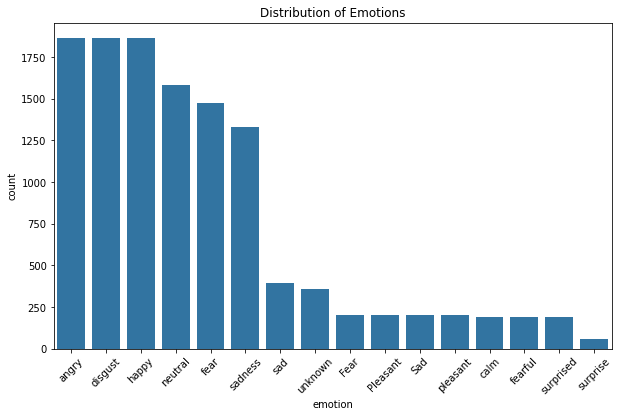

In [88]:
# distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

# this chart shows some a significant imbalance in the dataset. lets do some resampling
# Lets try using the SMOTE technique (Synthetic Minority Over-sampling):

In [89]:
# Lets combine columns that should be the same, such as 'Sad', 'sad', and 'sadness':

clean_data['emotion'] = clean_data['emotion'].str.lower()  # Convert to lowercase

# Replace specific values
clean_data['emotion'] = clean_data['emotion'].replace({
    'surprised': 'surprise',  # Change 'surprised' to 'surprise'
    'sadness': 'sad',          # Combine 'sadness', 'sad', 'Sad' to 'sad'
    'sad': 'sad',
    'sadness': 'sad',
    'pleasant': 'pleasant',
    'fear': 'fear',
    'fearful': 'fear',
})

# Check unique values after standardization
unique_emotions = clean_data['emotion'].unique()
print(unique_emotions)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'pleasant' 'unknown'
 'surprise' 'calm']


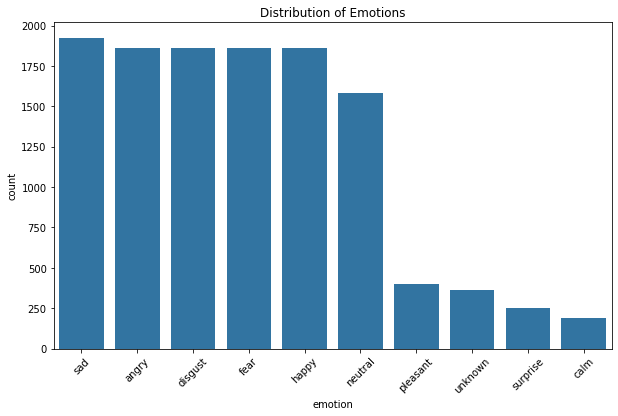

In [90]:
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

# this chart shows some a significant imbalance in the dataset.
# lets reduce the higher classes like sad, angry, dusgust and so on to 1500, 
# then use augmented audio for underrepresented classes, bringing them also to 1500. 

## Harmonizing sample sizes for target

In [93]:
eval_clean_data = clean_data.copy()

# Prepare the data
X = eval_clean_data.drop(columns=['emotion', 'filename', 'path'])
y = eval_clean_data['emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the original distribution of the training data
print("Original dataset shape:", Counter(y_train))

# Convert columns with object type (list/array) to their means for old models
# Note that 'mfccs_mean' is not used anymore, so we replace it with 'mfccs'
for col in ['mfccs', 'spectral_centroid', 'chroma', 'zero_crossing_rate', 'rms']:
    if col in X_train.columns:
        X_train[col] = X_train[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
        X_test[col] = X_test[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)

# Check if the columns were converted correctly
print(X_train.dtypes)
# Should all be floats!

Original dataset shape: Counter({'sad': 1544, 'fear': 1502, 'angry': 1498, 'happy': 1495, 'disgust': 1457, 'neutral': 1254, 'pleasant': 331, 'unknown': 281, 'surprise': 214, 'calm': 153})
mfccs_mean                    float32
mfccs_std                     float32
mfccs_skewness                float64
mfccs_kurtosis                float64
spectral_centroid_mean        float64
spectral_centroid_std         float64
spectral_centroid_skewness    float64
spectral_centroid_kurtosis    float64
chroma                        float64
zero_crossing_rate            float64
rms                           float64
pitch                         float64
dtype: object


In [95]:
# Handle null values
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Convert columns with list/array values to numeric
# Now using the updated feature names like 'mfccs_mean', 'spectral_centroid_mean', etc.
for col in ['mfccs_mean', 'mfccs_std', 'mfccs_skewness', 'mfccs_kurtosis', 
            'spectral_centroid_mean', 'spectral_centroid_std', 
            'spectral_centroid_skewness', 'spectral_centroid_kurtosis', 
            'chroma', 'zero_crossing_rate', 'rms']:
    eval_clean_data[col] = eval_clean_data[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
    # Convert to numeric, setting errors to 'coerce' which will turn invalid entries to NaN
    eval_clean_data[col] = pd.to_numeric(eval_clean_data[col], errors='coerce')

# Check for any NaN values after conversion
print("\nNumber of NaN values per column after conversion:")
print(eval_clean_data.isnull().sum())

# Remove rows with NaN values
eval_clean_data = eval_clean_data.dropna()

# Verify that there are no more NaN values
print("\nNumber of NaN values per column after dropping rows with NaNs:")
print(eval_clean_data.isnull().sum())

# Check final shape of the cleaned data
print("\nFinal shape of eval_clean_data:", eval_clean_data.shape)

X_train shape: (9729, 12)
y_train shape: (9729,)
X_test shape: (2433, 12)
y_test shape: (2433,)

Number of NaN values per column after conversion:
mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
path                          0
filename                      0
emotion                       0
dtype: int64

Number of NaN values per column after dropping rows with NaNs:
mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_cro

In [96]:
# Define the parameter grid and run grid search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] 
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Review the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

print() # new line for seperation

# evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best_tree = best_model.predict(X_test)

print("Decision Tree Accuracy (Best):", accuracy_score(y_test, y_pred_best_tree))
print("Confusion Matrix (Best):\n", confusion_matrix(y_test, y_pred_best_tree))
print("Classification Report (Best):\n", classification_report(y_test, y_pred_best_tree))


Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters found:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score:  0.47846550963415824

Decision Tree Accuracy (Best): 0.4722564734895191
Confusion Matrix (Best):
 [[246   0   9  23  63  11   4   1   8   0]
 [  2   8   3   2   2   8   0  14   0   0]
 [ 37   1 101  20  86  82  17  54   8   0]
 [ 53   0  24 105  58  48   1  67   5   0]
 [ 66   0  15  38 180  52   5   9   3   0]
 [  7   6  28  17  38 190   0  39   4   0]
 [  4   0   8   0   4   2  51   0   0   0]
 [  3   6  36  34  27  72   0 189   5   7]
 [  7   1   0   4   5   0   0   2  13   6]
 [  0   0   0   0   0   0   0   8   5  66]]
Classification Report (Best):
               precision    recall  f1-score   support

       angry       0.58      0.67      0.62       365
        calm       0.36      0.21      0.26        39
     disgust       0.45      0.25      0.32       406
        fear       0

#### Evaluation:
Accuracy of 46% is not great. 

Our f1-scores don't look super hot either. Let's address this!

## Audio Augmentation for Underrepresented Classes

Let's attempt to make the model better by evening the distribution. To do this, we will lower the more represented classes to 1500 each, and create synthetic data for the underrepresented classes. 

In [97]:
reduced_data = clean_data.copy()

# drop rows with 'unknown' emotion
reduced_data = reduced_data[reduced_data['emotion'] != 'unknown']
# Define the target count for high emotion classes
target_count_high = 1500

# Previously, I had randomly removed rows from the higher distributed classes.
# I believe this lead to information loss.
                                        
# Check the new distribution of the reduced data
print(reduced_data['emotion'].value_counts())

emotion
sad         1923
angry       1863
disgust     1863
fear        1863
happy       1863
neutral     1583
pleasant     400
surprise     252
calm         192
Name: count, dtype: int64


In [98]:
# audio augmentation to help with uneven data
def augment_audio(data, sr):
    # Time Stretching
    try:
        stretched_data = librosa.effects.time_stretch(data, rate=1.1)
    except Exception as e:
        stretched_data = data
    
    # Shifting 
    shift = np.random.randint(sr)
    shifted_data = np.roll(data, shift)
    
    # Volume adjustment
    amplitude_scale = np.random.uniform(low=0.8, high=1.2)
    adjusted_volume_data = data * amplitude_scale
    
    # Randomly choose one of the augmentation methods to apply
    augmentation_methods = [stretched_data, shifted_data, adjusted_volume_data]
    
    # Check for invalid values in augmentation methods
    valid_methods = [method for method in augmentation_methods if len(method) > 0 and not np.isnan(method).any() and not np.isinf(method).any()]
    
    if valid_methods:
        augmented_data = random.choice(valid_methods)
    else:
        augmented_data = data
    
    return augmented_data

In [99]:
# Create a new DataFrame for augmented data
augmented_data = reduced_data.copy()

# Lists to store augmented features
augmented_mfccs_mean_list = []
augmented_mfccs_std_list = []
augmented_mfccs_skewness_list = []
augmented_mfccs_kurtosis_list = []

augmented_spectral_centroid_mean_list = []
augmented_spectral_centroid_std_list = []
augmented_spectral_centroid_skewness_list = []
augmented_spectral_centroid_kurtosis_list = []

augmented_chroma_list = []
augmented_zero_crossing_rate_list = []
augmented_rms_list = []
augmented_pitch_list = []
augmented_emotions = []

# Define target count for underrepresented classes
target_count_underrepresented = 1500
target_count_neutral = 1800
underrepresented_emotions = ['pleasant', 'surprise', 'calm', 'neutral']

# Process and augment underrepresented emotions
for emotion in underrepresented_emotions:
    current_count = augmented_data[augmented_data['emotion'] == emotion].shape[0]
    if emotion == 'neutral':
        num_augments_needed = target_count_neutral - current_count
    else:
        num_augments_needed = target_count_underrepresented - current_count

    if num_augments_needed > 0:
        # Find all samples of this emotion in the dataset
        emotion_samples = augmented_data[augmented_data['emotion'] == emotion]
        
        # Augment samples until we reach the target count
        for _ in range(num_augments_needed):
            # Randomly select a sample to augment
            random_sample = emotion_samples.sample(n=1).iloc[0]
            audio_file = os.path.join(random_sample['path'], random_sample['filename'])
            
            try:
                # Load the audio file
                data, sr = librosa.load(audio_file, sr=None)

                # Perform augmentation (assuming augment_audio is defined elsewhere)
                augmented_data_sample = augment_audio(data, sr)

                # Extract features from the augmented audio
                augmented_features = extract_features(augmented_data_sample, sr=sr, from_file=False)

                # Check if the features are valid
                if isinstance(augmented_features, tuple) and len(augmented_features) == 9:
                    # Extract the MFCCs statistics (mean, std, skewness, kurtosis)
                    augmented_mfccs_mean_list.append(augmented_features[0])
                    augmented_mfccs_std_list.append(augmented_features[1])
                    augmented_mfccs_skewness_list.append(augmented_features[2])
                    augmented_mfccs_kurtosis_list.append(augmented_features[3])

                    # Extract Spectral Centroid statistics (mean, std, skewness, kurtosis)
                    augmented_spectral_centroid_mean_list.append(augmented_features[4][0])
                    augmented_spectral_centroid_std_list.append(augmented_features[4][1])
                    augmented_spectral_centroid_skewness_list.append(augmented_features[4][2])
                    augmented_spectral_centroid_kurtosis_list.append(augmented_features[4][3])

                    # Extract other features
                    augmented_chroma_list.append(augmented_features[5])
                    augmented_zero_crossing_rate_list.append(augmented_features[6])
                    augmented_rms_list.append(augmented_features[7])
                    augmented_pitch_list.append(augmented_features[8])
                    
                    # Append the emotion
                    augmented_emotions.append(emotion)
                else:
                    print(f"Warning: Invalid number of features returned by extract_features for '{audio_file}'")
            except Exception as e:
                print(f"Error processing {audio_file}: {str(e)}")

# After augmentation, create a DataFrame to store augmented features
augmented_df = pd.DataFrame({
    'mfccs_mean': augmented_mfccs_mean_list,
    'mfccs_std': augmented_mfccs_std_list,
    'mfccs_skewness': augmented_mfccs_skewness_list,
    'mfccs_kurtosis': augmented_mfccs_kurtosis_list,
    'spectral_centroid_mean': augmented_spectral_centroid_mean_list,
    'spectral_centroid_std': augmented_spectral_centroid_std_list,
    'spectral_centroid_skewness': augmented_spectral_centroid_skewness_list,
    'spectral_centroid_kurtosis': augmented_spectral_centroid_kurtosis_list,
    'chroma': augmented_chroma_list,
    'zero_crossing_rate': augmented_zero_crossing_rate_list,
    'rms': augmented_rms_list,
    'pitch': augmented_pitch_list,
    'emotion': augmented_emotions
})

# Check for null values in the augmented DataFrame
print("Null values in the augmented DataFrame:")
print(augmented_df.isnull().sum())

# Combine reduced data with augmented data
eval_aug_data = pd.concat([reduced_data, augmented_df], ignore_index=True)
print()

# Check the final distribution
print(eval_aug_data['emotion'].value_counts())

Null values in the augmented DataFrame:
mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
emotion                       0
dtype: int64
emotion
sad         1923
angry       1863
disgust     1863
fear        1863
happy       1863
neutral     1800
pleasant    1500
surprise    1500
calm        1500
Name: count, dtype: int64


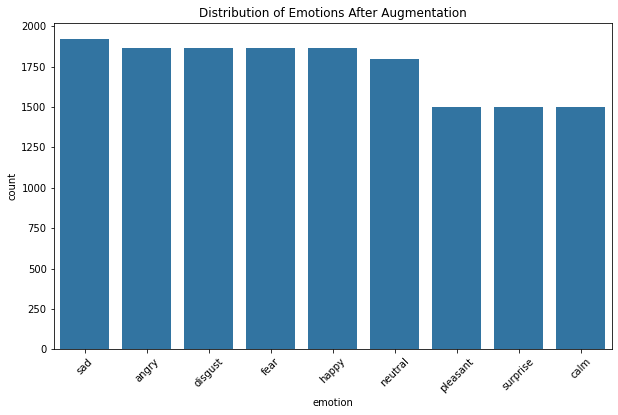

In [102]:
plt.figure(figsize=(10, 6))
sns.countplot(data=eval_aug_data, x='emotion', order=eval_aug_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions After Augmentation')
plt.xticks(rotation=45)
plt.show()

# We are no longer dropping values for higher classes - we do not want the data loss.
# augmented audio for underrepresented classes, bringing them to 1500. 
# augmented audio for 'neutral' class, bringing it to 1800 
#  (to balance this underrepresented class from the larger class group)

In [103]:
eval_aug_data.head()

,mfccs_mean,mfccs_std,mfccs_skewness,mfccs_kurtosis,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_skewness,spectral_centroid_kurtosis,chroma,zero_crossing_rate,rms,pitch,path,filename,emotion
0,-17.963037,26.37207,-0.51548,3.32999,1584.993070,600.410753,1.645968,5.914065,0.411293,0.101868,0.041986,1211.950684,dataset\Crema,1001_DFA_ANG_XX.wav,angry
1,-18.657297,21.019888,-0.498601,3.982956,1531.650487,590.708457,2.221739,8.718056,0.423961,0.093061,0.015996,1256.617188,dataset\Crema,1001_DFA_DIS_XX.wav,disgust
2,-18.552622,25.241508,-0.602645,4.156697,1489.088839,521.794373,2.785179,13.443495,0.413398,0.084286,0.045776,992.574402,dataset\Crema,1001_DFA_FEA_XX.wav,fear
3,-18.460817,24.993519,-0.653859,3.327673,1555.376035,476.260688,2.604170,11.342148,0.39482,0.084878,0.0423,1102.953003,dataset\Crema,1001_DFA_HAP_XX.wav,happy
4,-18.111607,20.89341,-0.480883,3.167808,1495.394997,492.130906,1.597144,6.070896,0.401279,0.082031,0.02045,1041.093628,dataset\Crema,1001_DFA_NEU_XX.wav,neutral


# Model Iterations


#### Evaluation v1:

Classification Report (grid search)

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.46    | 2433    |
| macro avg     | 0.43      | 0.43   | 0.43     | 2433    |
| weighted avg  | 0.46      | 0.46   | 0.45     | 2433    |

#### Evaluation v2:

Classification Report (grid search with SMOTE):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.71    | 5962    |
| macro avg     | 0.70      | 0.71   | 0.70     | 5962    |
| weighted avg  | 0.70      | 0.71   | 0.71     | 5962    |

#### Evaluation v3:

Classification Report (decision tree w/ augmentation and 1500 samples per category):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.58    | 2700    |
| macro avg     | 0.57      | 0.58   | 0.57     | 2700    |
| weighted avg  | 0.57      | 0.58   | 0.57     | 2700    |

Accuracy of 59%; certainly an imporovement! But nothing substantial. 

Despite evening the distribution, we are still not seeing the model perform well. This is likely because 7k records
is probably not enough to get good predictive capacity over our 7 categories. 

the f1-scores that indicate weaknesses in our model is: disgust, fear, happy. this tells me that maybe we shouldn't have deleted 

Let's engineer the categories into pos/neg binary classification and see if that improves our results.

#### Evaluation v4:

Classification Report (decision tree w/ even distribution, no deleting records):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.56    | 3135    |
| macro avg     | 0.57      | 0.59   | 0.57     | 3135    |
| weighted avg  | 0.55      | 0.56   | 0.54     | 3135    |

Accuracy of 55.34%: While this may seem like a drop, it's important to note that the dataset has been augmented, which can affect the accuracy score. 

F1-scores: 
- the f1-scores for underrepresented classes like 'disgust', 'fear', and 'happy' slightly improved compared to previous version.
- the f1-score for 'neutral' decreased slightly (0.02), which could be due to the additional augmented samples
- the f1-score for the other classes either remained or improved marginally

Precision / Recall:
- the recall for underrepresented classes has generally improved
- however, the precision (ability to not label negative instances as positive) has decreased, which could be due to the introduction of noise in the augmented data.

## Multiclassification with Neural Networks

#### Evaluation v7

Classification Report (neural network for multiclassification):

| Emotion   | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| angry     | 0.66      | 0.60   | 0.63     | 405     |
| calm      | 0.74      | 0.86   | 0.79     | 291     |
| disgust   | 0.52      | 0.30   | 0.38     | 383     |
| fear      | 0.71      | 0.22   | 0.34     | 388     |
| happy     | 0.39      | 0.40   | 0.39     | 364     |
| neutral   | 0.42      | 0.57   | 0.49     | 367     |
| pleasant  | 0.75      | 0.94   | 0.84     | 283     |
| sad       | 0.49      | 0.59   | 0.53     | 374     |
| surprise  | 0.58      | 0.89   | 0.70     | 280     |
| **accuracy** |           |        | 0.57     | 3135    |
| **macro avg** | 0.59      | 0.60   | 0.57     | 3135    |
| **weighted avg** | 0.58      | 0.57   | 0.55     | 3135    |

Not much better. Tried better feature extraction for only 2% increase (59%)


#### Evaluation v8:

Classification Report (Convolutional Neural Network with better features):

| Emotion    | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Angry      | 0.72      | 0.70   | 0.71     | 405     |
| Calm       | 0.77      | 0.97   | 0.86     | 291     |
| Disgust    | 0.45      | 0.31   | 0.37     | 383     |
| Fear       | 0.63      | 0.27   | 0.38     | 388     |
| Happy      | 0.46      | 0.43   | 0.44     | 364     |
| Neutral    | 0.49      | 0.63   | 0.55     | 367     |
| Pleasant   | 0.88      | 0.94   | 0.91     | 283     |
| Sad        | 0.51      | 0.63   | 0.57     | 374     |
| Surprise   | 0.70      | 0.94   | 0.80     | 280     |
| **Accuracy** |           |        | 0.62     | 3135    |
| **Macro Avg** | 0.62      | 0.65   | 0.62     | 3135    |
| **Weighted Avg** | 0.61      | 0.62   | 0.60     | 3135    |

Seeing some progress! This makes sense, since CNN's are better for audio data. 
Lets try a more advanced CNN Architecture, incorperating Batch Normalization, Dropout, and L2 Regularization.

In [105]:
print(len(eval_aug_data))
print(eval_aug_data['emotion'].value_counts())

eval_aug_data.head(20)

15675
emotion
sad         1923
angry       1863
disgust     1863
fear        1863
happy       1863
neutral     1800
pleasant    1500
surprise    1500
calm        1500
Name: count, dtype: int64


,mfccs_mean,mfccs_std,mfccs_skewness,mfccs_kurtosis,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_skewness,spectral_centroid_kurtosis,chroma,zero_crossing_rate,rms,pitch,path,filename,emotion
0,-17.963037,26.37207,-0.51548,3.32999,1584.993070,600.410753,1.645968,5.914065,0.411293,0.101868,0.041986,1211.950684,dataset\Crema,1001_DFA_ANG_XX.wav,angry
1,-18.657297,21.019888,-0.498601,3.982956,1531.650487,590.708457,2.221739,8.718056,0.423961,0.093061,0.015996,1256.617188,dataset\Crema,1001_DFA_DIS_XX.wav,disgust
2,-18.552622,25.241508,-0.602645,4.156697,1489.088839,521.794373,2.785179,13.443495,0.413398,0.084286,0.045776,992.574402,dataset\Crema,1001_DFA_FEA_XX.wav,fear
3,-18.460817,24.993519,-0.653859,3.327673,1555.376035,476.260688,2.604170,11.342148,0.39482,0.084878,0.0423,1102.953003,dataset\Crema,1001_DFA_HAP_XX.wav,happy
4,-18.111607,20.89341,-0.480883,3.167808,1495.394997,492.130906,1.597144,6.070896,0.401279,0.082031,0.02045,1041.093628,dataset\Crema,1001_DFA_NEU_XX.wav,neutral
5,-19.037416,19.278528,-0.311734,3.857102,1513.748780,612.127986,2.101667,7.437446,0.427224,0.087023,0.012455,1130.106445,dataset\Crema,1001_DFA_SAD_XX.wav,sad
6,-17.17767,27.92971,-0.568144,2.947689,1721.615099,670.983957,1.693535,6.386756,0.384599,0.116883,0.049829,1165.974365,dataset\Crema,1001_IEO_ANG_HI.wav,angry
7,-19.042795,20.650948,-0.859197,3.966737,1382.379410,417.442372,2.030664,7.023072,0.431309,0.077945,0.016672,852.710693,dataset\Crema,1001_IEO_ANG_LO.wav,angry
8,-18.658516,24.008181,-0.445653,3.146925,1519.672019,691.802134,2.833488,12.462970,0.392562,0.100239,0.021257,883.379822,dataset\Crema,1001_IEO_ANG_MD.wav,angry
9,-18.313822,25.082436,-0.444414,3.029579,1653.022971,595.904416,1.571637,4.769554,0.446643,0.107577,0.029184,1174.250610,dataset\Crema,1001_IEO_DIS_HI.wav,disgust


### Data Preprocessing

In [131]:
# Drop non-numeric columns like 'filename' and 'path' before fitting the model
X = eval_aug_data.drop(columns=['emotion', 'filename', 'path'])

# Extract the labels (emotions)
y = eval_aug_data['emotion']

# Convert columns with object type (lists or arrays) to their means
# Use correct column names after feature extraction
for col in ['mfccs_mean', 'mfccs_std', 'mfccs_skewness', 'mfccs_kurtosis',
            'spectral_centroid_mean', 'spectral_centroid_std', 
            'spectral_centroid_skewness', 'spectral_centroid_kurtosis', 
            'chroma', 'zero_crossing_rate', 'rms']:
    if col in X.columns:
        # Just in case, ensure that list/array values are converted to numeric
        X[col] = X[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)

# Handle any remaining NaN values
X = X.dropna()

# Encode the labels (emotions) as integers using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels for multiclass classification
y_one_hot = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print dataset shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12540, 12)
y_train shape: (12540, 9)
X_test shape: (3135, 12)
y_test shape: (3135, 9)


### Neural Network Model

In [132]:
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [133]:
# Define the CNN model
model = Sequential()

# 1D Convolutional Layer (for handling sequences like MFCCs)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# 1D Convolutional Layer 2
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Flatten the data to feed into dense layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for multi-class classification
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Model Training

In [134]:
# Reshape X_train and X_test to add a channel dimension for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test))

Epoch 1/50
392/392 [==============================] - 2s 3ms/step - loss: 1.5554 - accuracy: 0.4441 - val_loss: 1.3958 - val_accuracy: 0.4906
Epoch 2/50
392/392 [==============================] - 1s 2ms/step - loss: 1.3061 - accuracy: 0.5162 - val_loss: 1.2231 - val_accuracy: 0.5349
Epoch 3/50
392/392 [==============================] - 1s 2ms/step - loss: 1.2499 - accuracy: 0.5354 - val_loss: 1.1815 - val_accuracy: 0.5550
Epoch 4/50
392/392 [==============================] - 1s 2ms/step - loss: 1.1994 - accuracy: 0.5527 - val_loss: 1.1471 - val_accuracy: 0.5671
Epoch 5/50
392/392 [==============================] - 1s 2ms/step - loss: 1.1807 - accuracy: 0.5610 - val_loss: 1.1557 - val_accuracy: 0.5598
Epoch 6/50
392/392 [==============================] - 1s 2ms/step - loss: 1.1697 - accuracy: 0.5659 - val_loss: 1.1378 - val_accuracy: 0.5662
Epoch 7/50
392/392 [==============================] - 1s 2ms/step - loss: 1.1477 - accuracy: 0.5721 - val_loss: 1.1000 - val_accuracy: 0.5780
Epoch 

### Evaluation

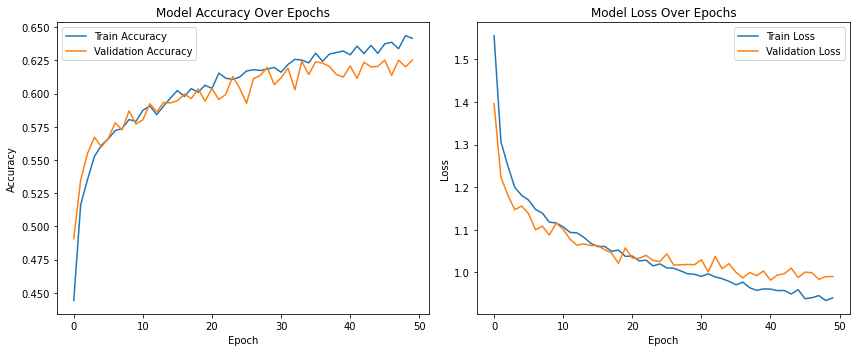

In [135]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

In [136]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=1)  # Using the reshaped X_test for CNN
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the test set
y_pred_proba = model.predict(X_test_cnn)  # Predictions as probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class indices
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to class indices

# Print evaluation metrics
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred))

# Save the model if needed
model.save('emotion_classification_model.h5')

98/98 [==============================] - 0s 855us/step - loss: 0.9903 - accuracy: 0.6252
Test Accuracy: 0.6252
98/98 [==============================] - 0s 790us/step

Classification Report:
               precision    recall  f1-score   support

       angry       0.72      0.70      0.71       405
        calm       0.81      0.96      0.88       291
     disgust       0.49      0.33      0.39       383
        fear       0.64      0.29      0.40       388
       happy       0.44      0.43      0.44       364
     neutral       0.47      0.61      0.53       367
    pleasant       0.88      0.95      0.91       283
         sad       0.53      0.65      0.58       374
    surprise       0.73      0.95      0.83       280

    accuracy                           0.63      3135
   macro avg       0.63      0.65      0.63      3135
weighted avg       0.62      0.63      0.61      3135

Confusion Matrix:
 [[284   3  20  12  54  16   0   1  15]
 [  0 280   0   0   0   0   0   0  11]
 [ 26  

H:\Anaconda\envs\learn-env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


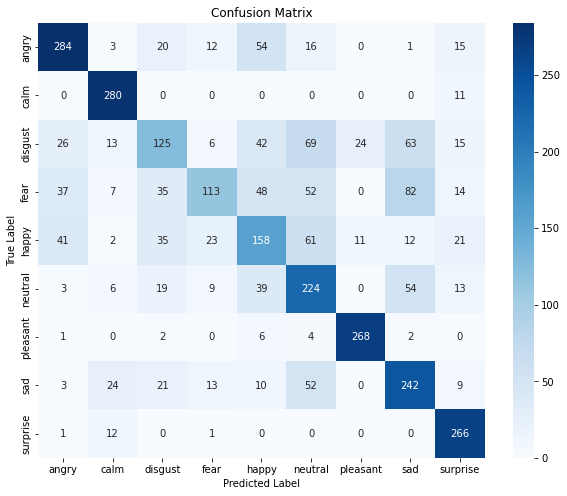

In [137]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Binary Classification

In the most recent report, the model's performance isn't satisfactory for reliably predicting specific emotions. The weighted average precision of 0.55 and F-score of 0.54 indicate that the model struggles to accurately classify the different categories. Having a relatively small dataset of 11,802 records can limit the model's ability to learn and generalize the complex patterns  of emotional recognition in voice. 

Simplifying the problem into positive/negative sentiments may improve metrics. With reduced complexity, the model could better grasp underlying patterns. Larger class sizes could mitigate data scarcity issues.

#### Evaluation v5

Classification Report (logistic regression for **binary classification**):  

| | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| Negative | 0.65 | 0.74 | 0.69 | 1536 |
| Positive | 0.36 | 0.27 | 0.31 | 825 |
| accuracy | | | | 0.57 | 2361 |
| macro avg | 0.51 | 0.51 | 0.50 | 2361 |
| weighted avg | 0.55 | 0.57 | 0.56 | 2361 |

As suspected, the 'positive' data suffered due to imbalanced classes. 

Let's augment some of the audio for the 'positive' class, and bring it closer to the negative class balance.

#### Evaluation v6
Classification Report (logistic regression for **binary classification with augmented data**): 

| | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| Negative | 0.65 | 0.74 | 0.69 | 1536 |
| Positive | 0.36 | 0.27 | 0.31 | 825 |
| accuracy | | | | 0.57 | 2361 |
| macro avg | 0.51 | 0.51 | 0.50 | 2361 |
| weighted avg | 0.55 | 0.57 | 0.56 | 2361 |

Having the same values as v5, I believe where we split the data caused data leakage.

In [ ]:
print(len(clean_data))
clean_data.head()

I'm going to consider 'neutral' as positive,

    1. because we need more 'positive' emotion
    2. because in our business problem, 'neutral' is a good thing!

In [ ]:
# Create a binary classification dataset
positive_emotions = ['happy', 'pleasant', 'surprise', 'calm', 'neutral']
negative_emotions = ['sad', 'angry', 'disgust', 'fear']

eval_bin_data = clean_data.copy()
eval_bin_data['binary_emotion'] = eval_bin_data['emotion'].apply(
    lambda x: 1 if x in positive_emotions else 0 if x in negative_emotions else None
)

# Drop rows with 'None' binary_emotion (neutral/other emotions)
eval_bin_data.dropna(subset=['binary_emotion'], inplace=True)

# Convert 'binary_emotion' to int
eval_bin_data['binary_emotion'] = eval_bin_data['binary_emotion'].astype(int)

In [ ]:
le = LabelEncoder()
eval_bin_data['emotion'] = le.fit_transform(eval_bin_data['emotion'])

# Keep 'path' and 'filename' for augmentation purposes
X = eval_bin_data.drop(['binary_emotion', 'emotion'], axis=1)
y = eval_bin_data['binary_emotion']

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Augment positive samples
positive_train_data = X_train[y_train == 1]
current_positive_count = len(positive_train_data)
target_positive_count = 7500
num_augments_needed = target_positive_count - current_positive_count

augmented_data = []
for _ in range(num_augments_needed):
    random_sample = positive_train_data.sample(n=1, random_state=42).iloc[0]
    audio_file = os.path.join(random_sample['path'], random_sample['filename'])
    
    try:
        data, sr = librosa.load(audio_file, sr=None)
        augmented_data_sample = augment_audio(data, sr)

        # Extract features and append
        augmented_features = extract_features(augmented_data_sample, sr=sr, from_file=False)
        if isinstance(augmented_features, (tuple, list)) and len(augmented_features) == 6:
            augmented_data.append(augmented_features)
        else:
            print(f"Invalid features for {audio_file}")
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

In [ ]:
# Create a DataFrame for augmented features with scalar values
augmented_df = pd.DataFrame(augmented_data, columns=[
    'mfccs_mean', 'spectral_centroid', 'chroma', 'zero_crossing_rate', 'rms', 'pitch'
])

# Concatenate augmented data with the original positive data
X_train_positive = X_train[y_train == 1].reset_index(drop=True).drop(['path', 'filename'], axis=1)
X_train_aug = pd.concat([X_train_positive, augmented_df], ignore_index=True)

# Combine with negative data
X_train_negative = X_train[y_train == 0].reset_index(drop=True).drop(['path', 'filename'], axis=1)
X_train_aug = pd.concat([X_train_negative, X_train_aug], ignore_index=True)
y_train_aug = pd.concat([y_train[y_train == 0], pd.Series([1] * len(augmented_df))], ignore_index=True)

# Make sure no sequences remain in the DataFrame (check types)
print(X_train_aug.dtypes)

# Train the model
model = LogisticRegression()
model.fit(X_train_aug, y_train_aug)

# Drop 'path' and 'filename' columns from the test set
X_test = X_test.drop(['path', 'filename'], axis=1)

# Evaluate on test set
y_pred = model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
print(final_data['binary_emotion'].value_counts())

---

Let's re-approach, and build a neural network model (which should me more appropriate for audio data!)

##